In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random

In [12]:
# Load the test data
with open('test_features_final', 'rb') as f:
    df_test_features = pickle.load(f)
df_test_features = df_test_features[(~df_test_features['id_update'].isna()) & (df_test_features['id_target'] != df_test_features['id_update'])]

In [13]:
features = ['scaled_rotation_x', 'scaled_rotation_y','normalized_time','scaled_velocity','scaled_angle','scaled_angle_to_end','scaled_curvature','scaled_distance_to_end']
max_time = df_test_features.groupby('id')['adjusted_time'].max()
min_time = df_test_features.groupby('id')['adjusted_time'].min()

# Extract sequences from the DataFrame
X = df_test_features.drop(['type_trajectory'], axis=1)
grouped = X.groupby('id')
trajectories = [group[features].values for _, group in grouped]
ids = list(grouped.groups.keys())
trajectory_type = df_test_features.groupby('id')['type_trajectory'].first().values

# Check the unique values of trajectory_type
unique_trajectory_types = np.unique(trajectory_type)
trajectory_type_to_index = {t: i for i, t in enumerate(unique_trajectory_types)}
trajectory_type_indices = np.array([trajectory_type_to_index[t] for t in trajectory_type])

# Define a function to pad sequences
def pad_sequences(sequences, maxlen, dtype='float32', padding='post', value=0):
    padded_sequences = np.full((len(sequences), maxlen, len(sequences[0][0])), value, dtype=dtype)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = seq[:maxlen]
        else:
            padded_sequences[i, :len(seq)] = seq
    return padded_sequences

# Pad the sequences
max_sequence_length = max([len(sequence) for sequence in trajectories])
trajectories_padded = pad_sequences(trajectories, max_sequence_length, padding='post')

sequence_length = trajectories_padded.shape[1]
number_of_features = trajectories_padded.shape[2]

# Convert the data to PyTorch tensors
test_sequences_tensor = torch.tensor(trajectories_padded, dtype=torch.float32)
test_types_tensor = torch.tensor(trajectory_type_indices, dtype=torch.long)


In [14]:
class TrajectoryDataset(Dataset):
    def __init__(self, sequences, types, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.types = torch.tensor(types, dtype=torch.int64)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.types[idx], self.labels[idx]
    
class TrajectoryModel(nn.Module):
    def __init__(self, num_trajectory_types, number_of_features, sequence_length):
        super(TrajectoryModel, self).__init__()
        self.lstm = nn.LSTM(number_of_features, 50, bidirectional=True, batch_first=True)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.embedding = nn.Embedding(num_trajectory_types, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(100 + 2, 100)  # 100 from LSTM + 2 from embedding
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, x, type_input):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(0, 2, 1)  # (batch_size, num_features, seq_len)
        avg_pool_out = self.avg_pool(lstm_out).squeeze(-1)  # (batch_size, 100)
        embedded_type = self.embedding(type_input)
        embedded_type = self.flatten(embedded_type)
        combined = torch.cat((avg_pool_out, embedded_type), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x


In [15]:
models = 'stop_turn_model.pth'
model_name = {'stop_turn_model.pth': 'stop_turn'}

# Initialize an empty DataFrame for the result
df_predicted = pd.DataFrame({'id': ids })

# Initialize and load the model
model = TrajectoryModel(len(unique_trajectory_types), number_of_features, sequence_length)
model.load_state_dict(torch.load(f'/Users/avitalvasiliev/Documents/GitHub/ExtractingTurningPointGUI/{models}'))
model.eval()

# Initialize a list to store predictions
predictions = []

# Make predictions using the model
with torch.no_grad():
    outputs = model(test_sequences_tensor, test_types_tensor)
    predictions.extend(outputs.squeeze().tolist())

# Convert each label's predictions into a DataFrame
column_name = model_name[models]
df_temp = pd.DataFrame({column_name: predictions, 'id': ids})

# Merge the temporary DataFrame with the main annotated DataFrame
if df_predicted.empty:
    df_predicted = df_temp
else:
    df_predicted = df_predicted.merge(df_temp, on='id', how='outer')

# Drop rows with missing values
df_predicted.dropna(inplace=True)

# Merge df_predicted with df_test_features to add recording_day, file_id, and video_in_file_id
df_predicted = df_predicted.merge(df_test_features[['recording_day', 'file_number', 'trial_number_in_file','id']], on='id', how='left')
df_predicted = df_predicted.drop_duplicates(subset='id')


In [17]:
df_predicted

,id,stop_turn,recording_day,file_number,trial_number_in_file
0,10,0.288671,32,1,10
179,15,0.348064,32,1,15
334,20,0.330375,32,1,20
499,25,0.367350,32,1,25
661,30,0.337742,32,1,30
...,...,...,...,...,...
25813,1309,0.330990,32,15,89
25984,1314,0.308331,32,15,94
26156,1324,0.334882,32,15,104
26314,1334,0.315205,32,15,114


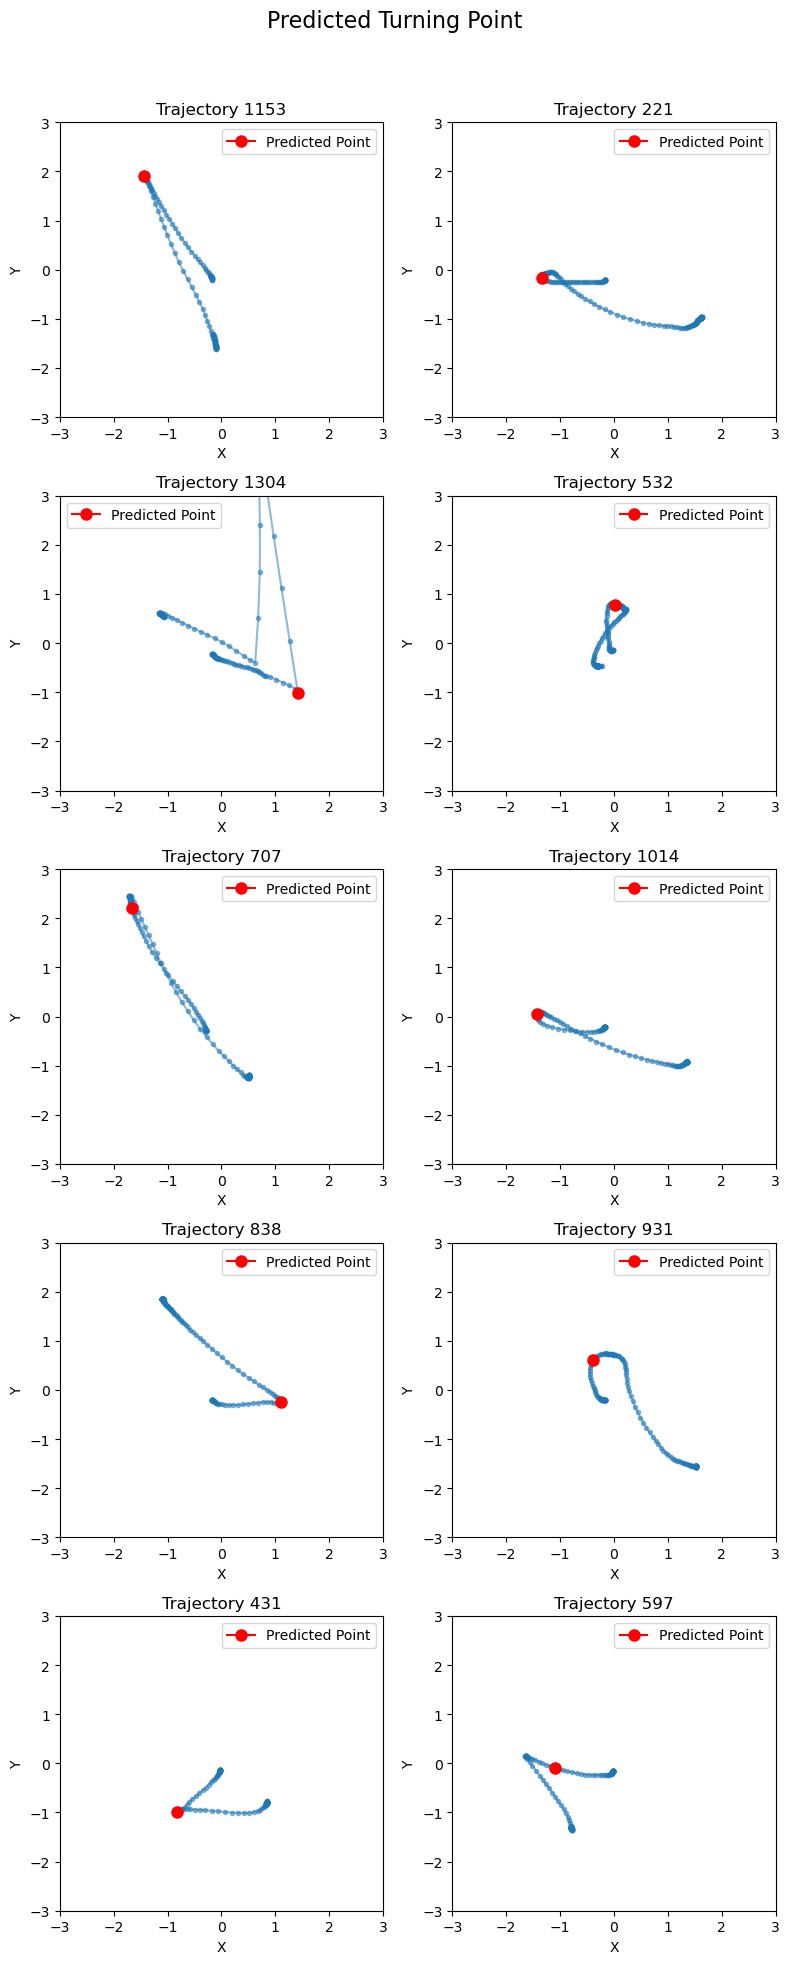

In [16]:
# Function to plot a trajectory
def plot_trajectory(ax, df, predicted_time):
    ax.plot(df['scaled_rotation_x'], df['scaled_rotation_y'], marker='o', alpha=0.5, markersize=3)
    # Get the closest index to the predicted start turning time
    predicted_idx = (df['normalized_time'] - predicted_time).abs().idxmin()
    predicted_x = df.loc[predicted_idx, 'scaled_rotation_x']
    predicted_y = df.loc[predicted_idx, 'scaled_rotation_y']
    ax.plot(predicted_x, predicted_y, marker='o', color='red', label='Predicted Point', markersize=8)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Randomly select 10 indices from the test data
random_indices = random.sample(sorted(df_test_features['id'].unique()), 10)

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(8, 20))  
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    ax = axes[i]
    # Extract the DataFrame for the current trajectory
    df = df_test_features[df_test_features['id'] == idx]
    # Use the 'id' to get the predicted time
    predicted_time = df_predicted.loc[df_predicted['id'] == idx, 'stop_turn'].values[0]
    plot_trajectory(ax, df, predicted_time)
    ax.set_title(f'Trajectory {idx}')

fig.suptitle('Predicted Turning Point', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()
